In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from util            import *
from basics          import *
from simulate_data   import *
from estimators      import *
from config          import *
from datasets        import *
from lgcp2d          import *
from functools       import lru_cache as cache
from opt_einsum      import contract
from scipy.io        import loadmat
from IPython.display import clear_output
configure_pylab()

from scipy.fft import *

import lgcp2d

# Set the desired precision here; 32 is faster but you might need 64
# if you encounter a poorly conditioned problem
lgcp2d.set_precision(32)

from lgcp2d import diagonal_fourier_lowrank

# Set constants

In [2]:
tol    = 1e-6      # Newton convergence tolerance
mintol = 1e-8      # Minimum residual tolerance

# Grid size ( bins per linear distance )
# (this must be even)
# You want this to be fine enough to simulation continuous space
# but not so fine that the computer runs out of memory.
# 128 is the magic number.
L      = 128       

res    = 50        # Upsampling/interpolation resolution when estimating period
pad    = 0.7       # Pad to avoid wrap-around from circular convolution; 0.5 = no padding
Fs     = 50.0      # Sample rate of data in Hz ( samples/second )
Δt     = 1/Fs      # seconds / sample
Fl     = 0.25      # Low-frequency cutoff in Hz for smoothing path trajcetory for heading
rP     = sqrt(2)   # Range (ratio) to search for optimal period
rβ     = 10^3      # Range (ratio) to search for optimal kernel height
NP     = 11        # Period search grid resolution
Nβ     = 11        # Kernel height search grid resolutions

# Find and load data

(8,)
cm  per spatial bin 3.5515668935089524
cm² per spatial bin 12.61362739906883
Period is 38.214860 cm (10.760000 bins)


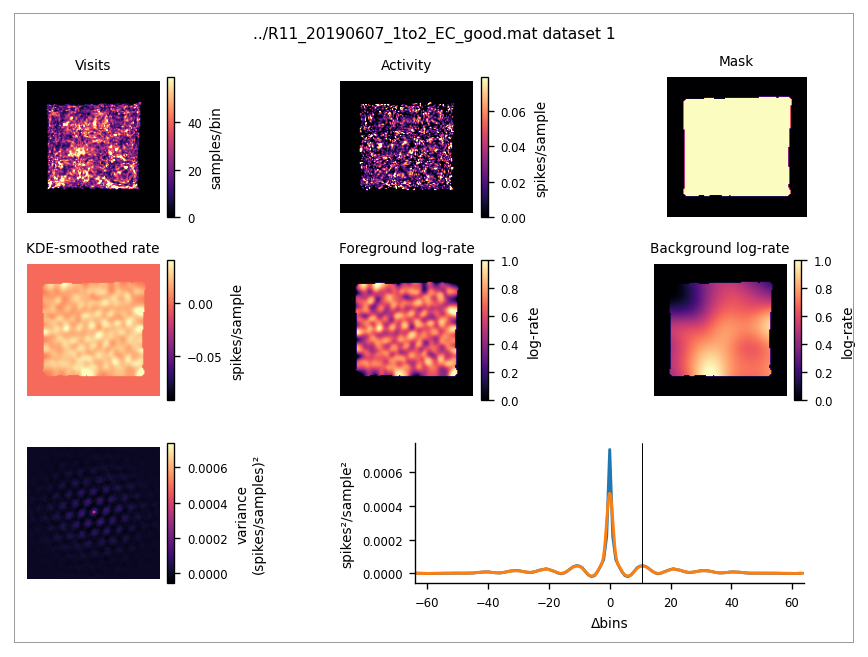

In [3]:

# 2D grid coordinates as complex numbers
coords = zgrid(L)
bins   = linspace(0,1,L+1,dtype='float32')

# Resolution for the camera used to record R1 is 350px/m;
# resolution for other rats (R11 and R18) was 338px/m
#px_p_meter = 338
#dataset    = 'R18_20200131_1to2_EC_good.mat'
px_p_meter = 338
dataset    = 'R11_20190607_1to2_EC_good.mat'
#px_p_meter  = 350
#dataset     = 'R1_20190823_2to1_EC_good.mat'

# Get specific dataset
scale,mask,n,y,P,bgσ,lλb,fgσ,lλf,σ0 = prepare_dataset(
    datadir+dataset,
    1,
    L,
    pad,
    doplot=True)

# Record grid scale
bins_p_meter = scale*L*px_p_meter
cm_p_bin     = 100/bins_p_meter
Δx           = cm_p_bin**2
print('cm  per spatial bin',cm_p_bin)
print('cm² per spatial bin',cm_p_bin**2)
print('Period is %f cm (%f bins)'%(P*cm_p_bin,P))


Using 541 components out of 16384
Δt = 2637 ms  elapsed for took


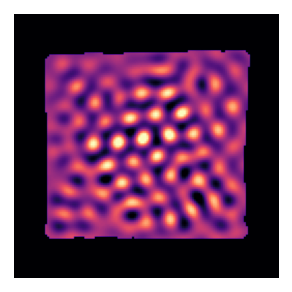

In [4]:
foo = diagonal_fourier_lowrank(n,y,lλf,lλb,L,σ0*1e-6,P)
tic()
μh,v,l,lpy = coordinate_descent(foo,tol=1e-4)
tic('took')
μ = foo.F.T@μh
showim(exp((μ+v/2).reshape(L,L)),mask=mask)

In [5]:
P_lo = P/rP
P_hi = P*rP
β_lo = 1/rβ
β_hi = 1*rβ
Ps   = float32(exp(linspace(log(P_lo),log(P_hi),NP)))
βs   = float32(exp(linspace(log(β_lo),log(β_hi),Nβ))[::-1])

'''
lpy_ = []
for β in progress_bar(βs):
    foo = diagonal_fourier_lowrank(n,y,μ0,L,σ0/β,P)
    μh,v,l,lpy = coordinate_descent(diagonal_fourier_lowrank(n,y,μ0,L,σ0/β,P))
    lpy_.append(lpy)
plot(lpy_)
notify('DONE')

lpy_ = []
for p in progress_bar(Ps):
    foo = diagonal_fourier_lowrank(n,y,μ0,L,σ0,p)
    μh,v,l,lpy = coordinate_descent(foo)
    lpy_.append(lpy)
plot(lpy_)
notify('DONE')
'''

"\nlpy_ = []\nfor β in progress_bar(βs):\n    foo = diagonal_fourier_lowrank(n,y,μ0,L,σ0/β,P)\n    μh,v,l,lpy = coordinate_descent(diagonal_fourier_lowrank(n,y,μ0,L,σ0/β,P))\n    lpy_.append(lpy)\nplot(lpy_)\nnotify('DONE')\n\nlpy_ = []\nfor p in progress_bar(Ps):\n    foo = diagonal_fourier_lowrank(n,y,μ0,L,σ0,p)\n    μh,v,l,lpy = coordinate_descent(foo)\n    lpy_.append(lpy)\nplot(lpy_)\nnotify('DONE')\n"

# Sweep β and optimize 

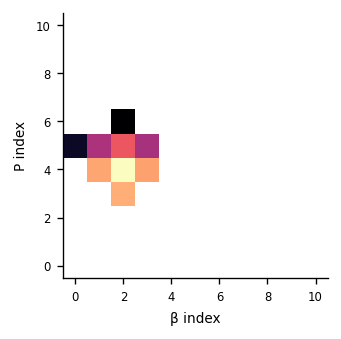

<IPython.core.display.Javascript object>

In [6]:
from IPython.display import clear_output

ip = NP//2
iβ = 0
p  = Ps[ip]
β  = βs[iβ]

#μh,v,_,lpy = infer(μh,v,float(β),float(p))
μh,v,l,lpy = coordinate_descent(diagonal_fourier_lowrank(n,y,lλf,lλb,L,σ0/β,p))
print('\tβ[%d] ='%iβ,β,'\tlpy = ',lpy)
μhref,vref = μh,v

from plot import *

results = np0.empty((NP,Nβ),dtype='object')

def current_best():
    global results
    lpys    = array([-inf if r is None else np.sum(array(r[4])) for r in results.ravel()])
    bestidx = argmax(lpys)
    bestP,bestβ = unravel_index(bestidx,results.shape)
    return bestP, bestβ, lpys[bestidx]  

def search(ip,iβ,suggested_direction=None):
    global results
    # Return if out of bounds; Return memoized if possible; 
    if iβ<0 or ip<0 or iβ>=Nβ or ip>=NP: return
    if results[ip,iβ]: return
    
    print('P[%d]=%0.2f β[%d]=%0.2f'%(ip,Ps[ip],iβ,βs[iβ]))
    
    # Get initial conditions via extrapolation when possible
    if iβ+2<Nβ and results[ip,iβ+1] and results[ip,iβ+2]:
        (μh1,v1),(μh2,v2) = results[ip,iβ+1][:2], results[ip,iβ+2][:2]
        μh = 2*μh1 - μh2
        v  = 2*v1  - v2
    elif iβ>=2 and results[ip,iβ-1] and results[ip,iβ-2]:
        (μh1,v1),(μh2,v2) = results[ip,iβ-1][:2], results[ip,iβ-2][:2]
        μh = 2*μh1 - μh2
        v  = 2*v1  - v2
    elif iβ+1<Nβ and results[ip,iβ+1]: μh,v = results[ip,iβ+1][:2]
    elif iβ>=1   and results[ip,iβ-1]: μh,v = results[ip,iβ-1][:2]
    elif ip+1<NP and results[ip+1,iβ]: μh,v = results[ip+1,iβ][:2]
    elif ip>=1   and results[ip-1,iβ]: μh,v = results[ip-1,iβ][:2]
    else: μh,v = μhref,vref
    
    β = βs[iβ]
    p = Ps[ip]
    #μh,v,l,lpy = infer(μh,v,float(β),float(p))
    foo = diagonal_fourier_lowrank(n,y,lλf,lλb,L,σ0/β,p)
    μh,v,l,lpy = coordinate_descent(foo)
    μ = foo.F.T@μh 
    
    results[ip,iβ] = (μ,μh,v,l,lpy)
    print('P[%d]=%0.2f β[%d]=%0.2f loss=%f lpy=%f'%(ip,Ps[ip],iβ,βs[iβ],np.sum(array(l)),lpy))
    clear_output(wait=True)
    figure()
    imshow(array([r[4] if not r is None else nan for r in results.ravel()]).reshape(NP,Nβ))
    xlabel('β index')
    ylabel('P index')
    simpleaxis()
    show()
    
    # Recursively search nearby
    search_directions = {(0,1),(0,-1),(1,0),(-1,0)}
    # Continue along previous trajectory, if any
    if not suggested_direction is None:
        Δp,Δβ = suggested_direction
        if current_best()[:2]==(ip,iβ):
            search(ip+Δp,iβ+Δβ,suggested_direction=(Δp,Δβ))
            search_directions -= {(Δp,Δβ)}
    # Try other trajectories
    for Δp,Δβ in search_directions:
        if current_best()[:2]!=(ip,iβ): break
        search(ip+Δp,iβ+Δβ,suggested_direction=(Δp,Δβ))
    return

ip = NP//2
iβ = 0

search(ip,iβ)

notify('DONE')

Optimized kernel height β=3.737193
Optimized kernel period P=10.039435
10.039435 3.7371929
Using 3613 components out of 16384


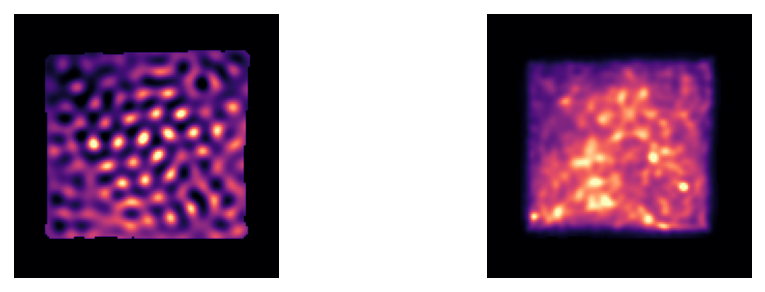

In [7]:
bestP, bestβ = current_best()[:2]
μ,μh,v,l,lpy = results[bestP,bestβ]
λ = exp(μ + lλb.ravel() + v/2)
subplot(121)
showim(λ.reshape(L,L),mask=mask)
subplot(122)
showim(1/v.reshape(L,L),mask=mask)
print('Optimized kernel height β=%f'%βs[bestβ])
print('Optimized kernel period P=%f'%Ps[bestP])

print(Ps[bestP], βs[bestβ])
foo = diagonal_fourier_lowrank(n,y,lλf,lλb,L,σ0/bestβ,bestP)

# Further analyses

To continue where we left off in the paper, we now need to:

- Infer maps for a range of angles
- Sample to show posterior

# Sampling from the posterior

In [8]:
bestβ,bestP,σ0/βs[bestβ],Ps[bestP]

(2, 4, 0.052270148243077824, 10.039435)

Using 609 components out of 16384


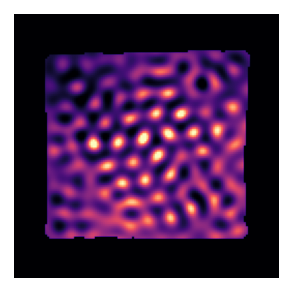

In [9]:
foo = diagonal_fourier_lowrank(n,y,lλf,lλb,L,σ0/βs[bestβ],Ps[bestP])
μh,v,l,lpy = coordinate_descent(foo)
μ = foo.F.T@μh 
λ = exp(μ + lλb.ravel() + v/2)
Σq = foo.fast_low_rank_covariance(μh,v)
Cq = float32(chol(Σq))
showim(λ.reshape(L,L),mask=mask)

0.024141855822127595 0.021399627


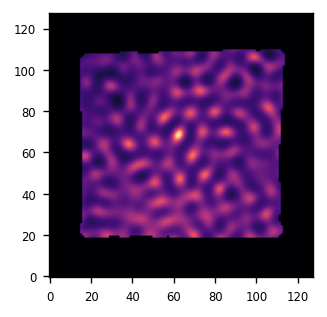

In [10]:
n,y,μ0,L,R,use2d,F,Λ,h2e,M = foo.cached

nsamples = 500
q = μh[:,None] + Cq@float32(randn(R,nsamples))
bigger = zeros((L,L,nsamples),dtype='float32')
bigger[use2d,:] = q
bigger = fft2(bigger,axes=(0,1),norm='ortho')
bigger = bigger.real + bigger.imag
λ = exp(lλb.reshape(L,L)[:,:,None] + bigger)
imshow(λ[:,:,100]*mask)
print(mean(λ.reshape(L*L,nsamples)[mask.ravel()]), mean(y.ravel()[mask.ravel()]))

In [11]:
from posterior import *

resolution = 4
bigmask = fft_upsample_2D(mask,resolution)>0.1
q = fft_upsample_2D(λ.T,resolution)
J = sum(findpeaks(q.T),2)/nsamples

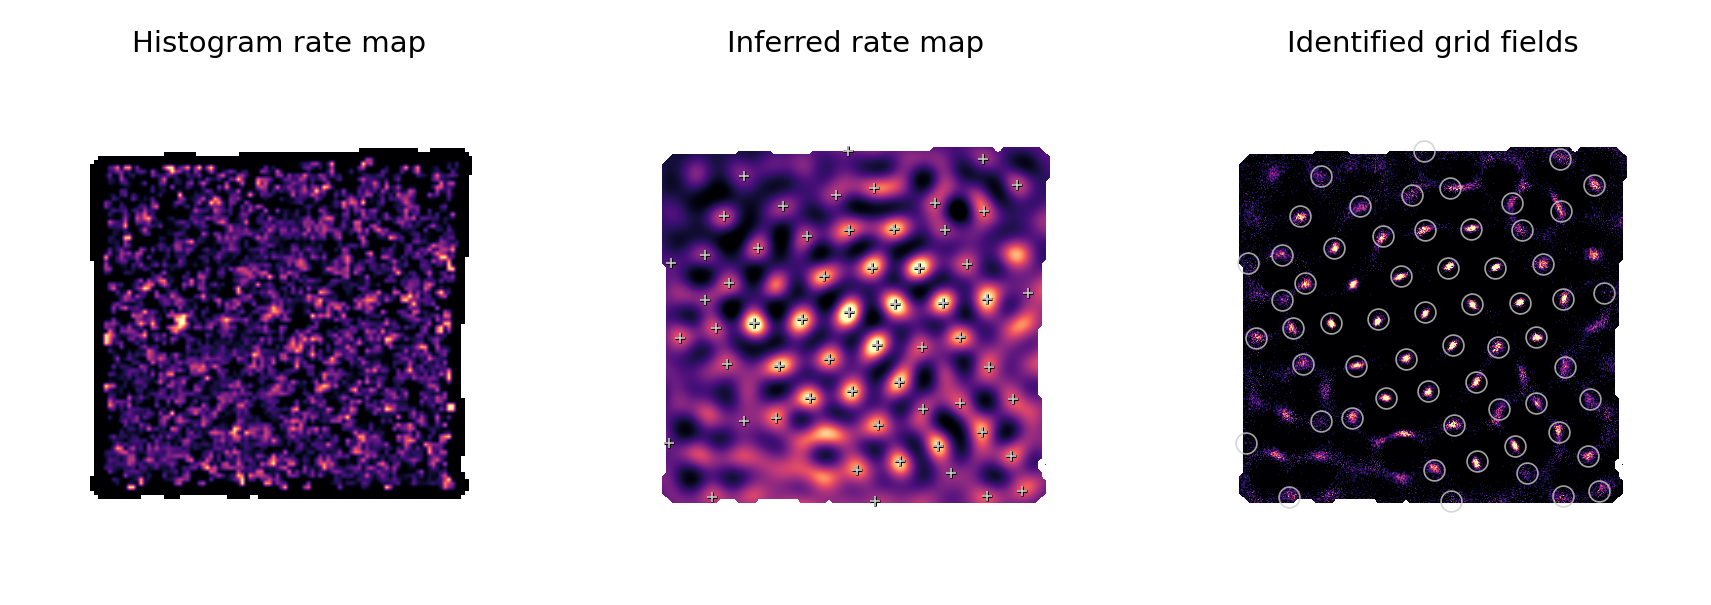

In [12]:
ry,rx = where(findpeaks(J*bigmask,r=int(P/2*resolution)))
J2 = copy(J)
J2[~bigmask]=nan

figure(dpi=300,figsize=(6,2))

subplot(131)
imshow(pscale(y.reshape(L,L)*(1/mask)),interpolation='bilinear')
axis('off')
#J2[J2<=0]=NaN
#imshow(slog(J2),cmap='turbo')
#scatter(rx,ry,facecolor=(0,)*4,edgecolor=(1,)*4,lw=.5,s=3)
title('Histogram rate map')

subplot(132)
q = exp(fft_upsample_2D((μ+μ0+v/2).reshape(L,L)))
q[~bigmask] = nan
showim(q,mask=bigmask)
#J2[J2<=0]=NaN
#imshow(slog(J2),cmap='turbo')
scatter(rx,ry,color=(0.,)*3,lw=0.4*1.75,s=5,marker='+')
scatter(rx,ry,color=(0.8,)*3,lw=0.4,s=5,marker='+')
tight_layout()
title('Inferred rate map')

subplot(133)
showim(J2)
scatter(rx,ry,facecolor=(0,)*4,edgecolor=(0.8,)*4,lw=0.4,s=25)
title('Identified grid fields')

tight_layout()

# TODO

- Get scales at different positions (grid properties everywhere)
- Check if peaks stay in place (they do)
- We also did heading dependence; Not sure what to make of this -- biggest issue was is it REAL? or just NOISE 
    - Is it just from having less data? 
    - Data is overdispersed so you can't just Poisson resample
- Simulate data with more granualrity to see if edge effects are related to understampling or from some real disorganization near the edges? 
    - Test fake grid but real path
- Restting near walls? Path/heading dependence? Less confidence in the center?
- Try to get local correlations/shifts for east/west filtered maps in different directions -- are there regional shifts? 
- Weighted average of multiple maps?
- A way to predict a map better using some behavioral variable, sich that conditioned on this the map has lower variance, but still, the average map looks the same?
- Oh yeah do the time shift : advance all spike by 100 ms (2 samples).

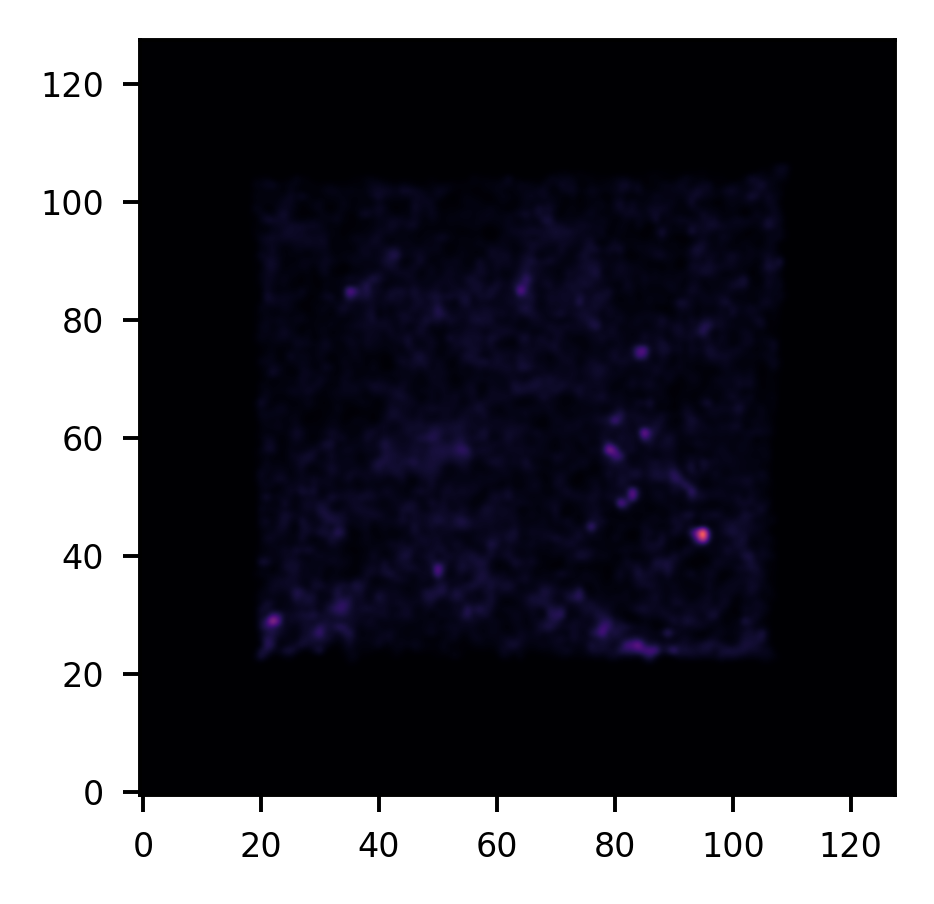

In [13]:
figure(dpi=400)
imshow(n.reshape(L,L),interpolation='bicubic')

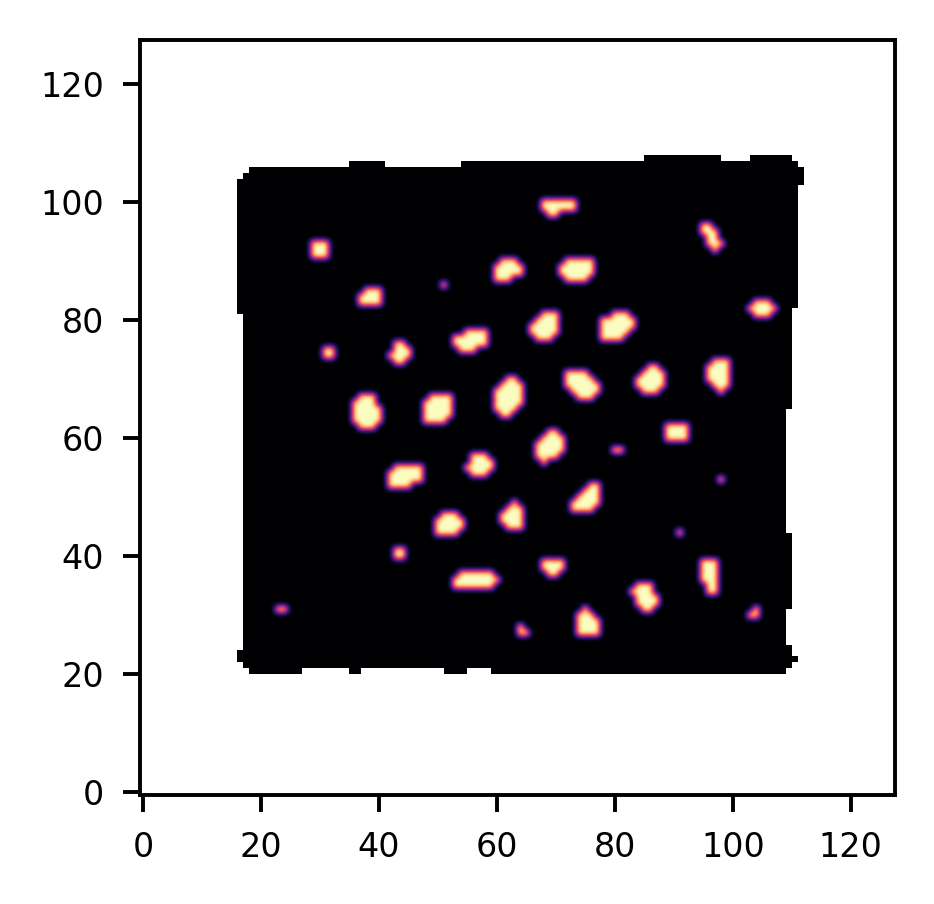

In [14]:
λ  = exp(μ + μ0 + v/2)

figure(dpi=400)
imshow((1.0/mask)* abs((μ/sqrt(v))>1.96 ).reshape(L,L),interpolation='bicubic')

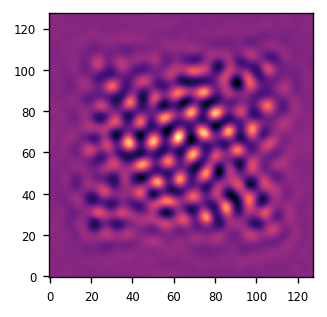

In [15]:
imshow(μ.reshape(L,L)/sqrt(v.reshape(L,L)))

# Infer maps for a range of angles 

In [16]:
'''
Use low-pass filtered velocity angle as heading 
Positive dx is eastwards
Negative dx is westwards
Positive dy is northwards
Negative dy is southwards
Angle is computed as if a complex number
North is +90, West is ±180, South is -90, and East is 0.
So, sin(θ) is the vertical direction, with sin(θ)=1 being northwards.
Likewise cos(θ) is the horizontal direction, with cos(θ)=1 being eastwards.
North: positive sin(θ)
South: negative sin(θ)
East : positive cos(θ)
West : negative cos(θ)
φ=0    : West
φ=1/2π : South
φ=π    : East
φ=3/2π : North
'''
φW,φS,φE,φN = 0, pi/2, pi, 3*pi/2
φs  = linspace(0,2*pi,90+1)[:-1]
φiW = argmin(abs(φs-φW))
φiS = argmin(abs(φs-φS))
φiE = argmin(abs(φs-φE))
φiN = argmin(abs(φs-φN))